In [1]:
from grape.utils import DataSet
data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
train, test, val = data.get_splits()

from grape.models import MGConv, SimpleGNN
import torch

node_hidden_dim = 64
batch_size = 32

model_message = MGConv(num_layers=5, edge_hidden_dim=64, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)

model = SimpleGNN(model_message=model_message,
                      input_pool_size=node_hidden_dim, 
                      output_size=1)

device = torch.device('cpu')

from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                   loss_func = loss_func,
                                   optimizer = optimizer,
                                   train_data_loader= train,
                                   val_data_loader = val,
                                   batch_size=batch_size,
                                   epochs=1,
                                   early_stopping=True,
                                   patience=20)

from grape.utils import test_model
test_model(model = model,
           test_data_loader= test,
           loss_func= loss_func);


from grape.utils import pred_metric
from grape.utils import SubSet, torch_subset_to_SubSet
import numpy as np

# Generate predictions (we save the latents for later)
preds, lats = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None)

test = torch_subset_to_SubSet(test)

lats = lats.cpu().detach().numpy()

pred_metric(preds, test.y)

Loaded dataset.


epoch=0, training loss= 0.802, validation loss= 0.636: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
100%|██████████| 10/10 [00:00<00:00, 212.33it/s]


Test loss: 0.712


100%|██████████| 10/10 [00:00<00:00, 206.12it/s]


{'mse': 0.725608113941884}

In [2]:
from sklearn.decomposition import PCA
model_pca = PCA(n_components=2)
model_pca.fit(lats)

V = model_pca.components_.T
print(V.shape)
print(lats.shape)
projection = lats@V
print(projection.shape)

(64, 2)
(299, 64)
(299, 2)


In [3]:
from grape.utils import classyfire, classyfire_result_analysis
ids = classyfire(test.smiles[:10])
mols_class, _ = classyfire_result_analysis()

Found log file in working directory.
Loaded existing log_file. Here is the data head:
  filename                                             smiles
0   0.json                                           CC(C)CCO
1   1.json                                 COC(=O)c1ccc(I)cc1
2   3.json                                              C=CCN
3   0.json                                   N#Cc1ccc(C#N)cc1
4   1.json  Clc1c(Cl)c(Cl)c(-c2c(Cl)c(Cl)c(Cl)c(Cl)c2Cl)c(...
5   2.json                                CCOC(=O)c1ccc(O)cc1
6   3.json             O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1
7   4.json                                O=C1CCN(c2ccccc2)N1
8   5.json                                         CC=C(C)CCC
9   6.json                        O=C(O)c1c(F)c(F)c(F)c(F)c1F
Mol 4 in log datafile, so skipping it.
Mol 9 in log datafile, so skipping it.


100%|██████████| 8/8 [00:14<00:00,  1.80s/it]


In [7]:
mols_class, _ = classyfire_result_analysis(idx=ids)
print(mols_class)
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
labels = enc.fit_transform(list(mols_class.values()))
print(labels)

{833: 'Lipids and lipid-like molecules', 1028: 'Hydrocarbons', 0: 'Benzenoids', 1: 'Organoheterocyclic compounds', 2: 'Hydrocarbons', 3: 'Lipids and lipid-like molecules', 5: 'Benzenoids', 6: 'Benzenoids', 7: 'Benzenoids', 8: 'Organic acids and derivatives'}
[2 1 0 4 1 2 0 0 0 3]


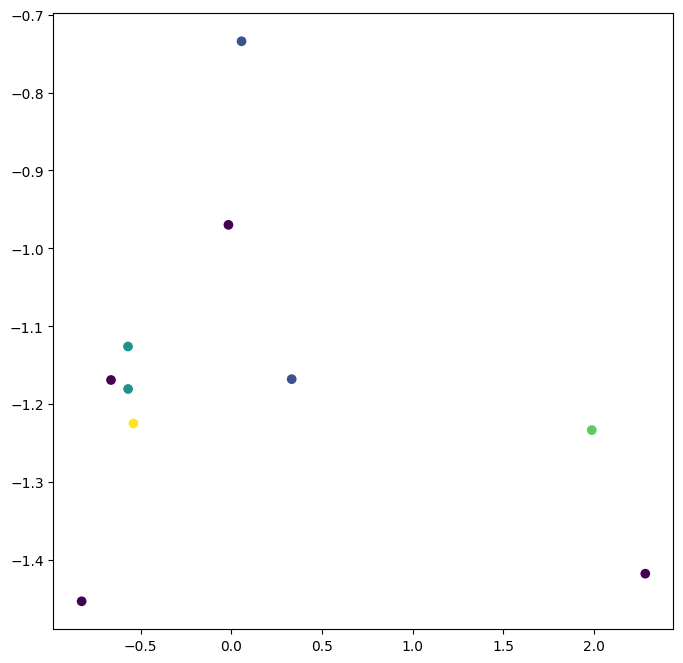

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(projection[:10,0], projection[:10,1], c = labels)


In [ ]:
import os
import pandas as pd

def file_in_dir(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return True


class classyfire(object):
    """
    
    """
    
    def __init__(self, path_to_export: str = None,
               record_log_file: bool = True, existing_log_file: str = None):
        
        if path_to_export is None:

            path_to_export = os.getcwd() + '/analysis_results'
    
            if not os.path.exists(path_to_export):
                os.mkdir(path_to_export)
    
            if existing_log_file is None:
                if file_in_dir(path_to_export, 'recorded_SMILES.csv'):
                    print('Found log file in working directory.')
                    existing_log_file = os.path.join(path_to_export,'recorded_SMILES.csv')
                    
        if record_log_file and existing_log_file is None:
            self.log_file = os.path.join(path_to_export, 'recorded_SMILES.csv')
            self.log_frame = pd.DataFrame({'filename':[], 'smiles':[]})
        
        elif existing_log_file is not None:
            try:
                self.log_frame = pd.read_csv(existing_log_file)
                log_file = existing_log_file
                print('Loaded existing log_file. Here is the data head:')
                #print(log_frame.head(10))
            except:
                print('Passed log_file is not valid, creating a new one.')
                self.log_file = os.path.join(path_to_export, 'recorded_SMILES.csv')
                self.log_frame = pd.DataFrame({'filename': [], 'smiles': []})
        
    #def retrieve_classyfiles(self):
        


In [1]:
from grape.datasets import BradleyDoublePlus
from grape.utils.data_splitting import taylor_butina_clustering
data = BradleyDoublePlus()

train, val, test = taylor_butina_clustering(data, threshold=0.8, radius=3)

Number of single molecule clusters: 124 and the ratio is: 0.432 of single molecule clusters.


In [4]:
print(train[0])

Data(x=[9, 42], edge_index=[2, 18], edge_attr=[18, 12], y=[1])
